In [18]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import os
from datetime import date, timedelta
import dask
import zarr
import torch
from torch.utils.data import Dataset, DataLoader

In [23]:
data_dir = './input_data/'
files = os.listdir(data_dir)
ds = xr.open_dataset(data_dir + 'cmems_mod_glo_phy_my_0.083deg_P1D-m_multi-vars_70.00W-40.00W_25.00N-45.00N_0.49m_2010-01-01-2020-12-31.nc')
ds_m = xr.open_dataset(data_dir + 'glorys_gulfstream_means.nc')
# ds
# ds = xr.open_zarr('./input_data/glorys_gulfstream_anomaly_zarr', consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 241, longitude: 361, time: 4018)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 25.0 25.08 25.17 25.25 ... 44.83 44.92 45.0
  * longitude  (longitude) float32 -70.0 -69.92 -69.83 ... -40.17 -40.08 -40.0
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
Data variables:
    so         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.0.10

In [15]:
ds = zarr.open('./input_data/glorys_gulfstream_anomaly_zarr')
ds['so'].chunks

(30, 1, 60, 90)

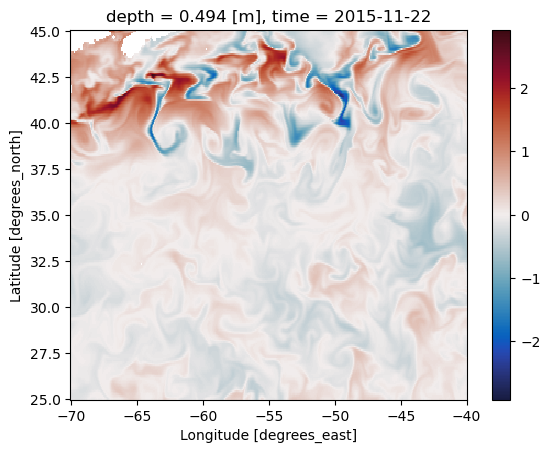

In [43]:
(ds['so']-ds_m['mso']).sel(time='2015-11-22').plot(cmap = cmocean.cm.balance)

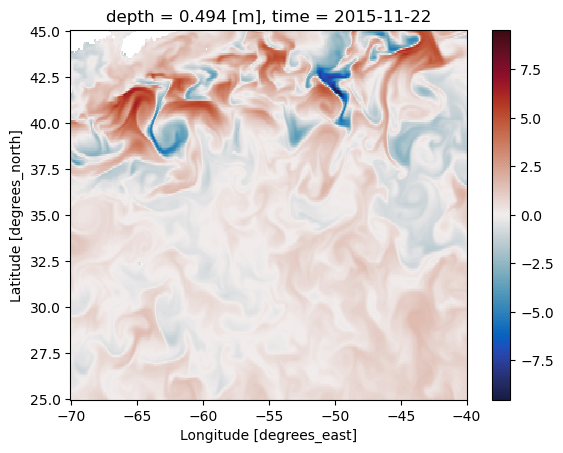

In [44]:
(ds['thetao']-ds_m['mthetao']).sel(time='2015-11-22').plot(cmap = cmocean.cm.balance)

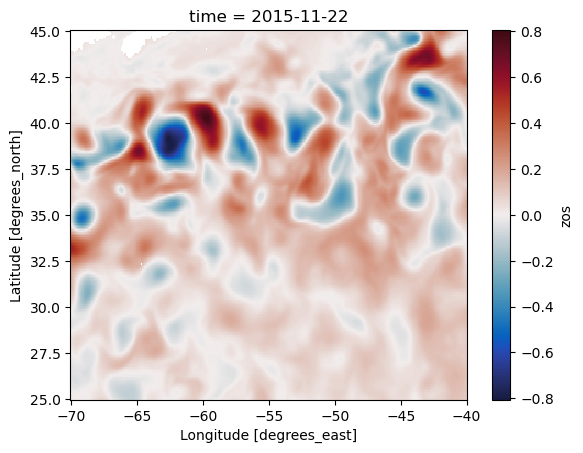

In [32]:
(ds['zos'].sel(time='2015-11-22')-mdt).plot(cmap = cmocean.cm.balance)

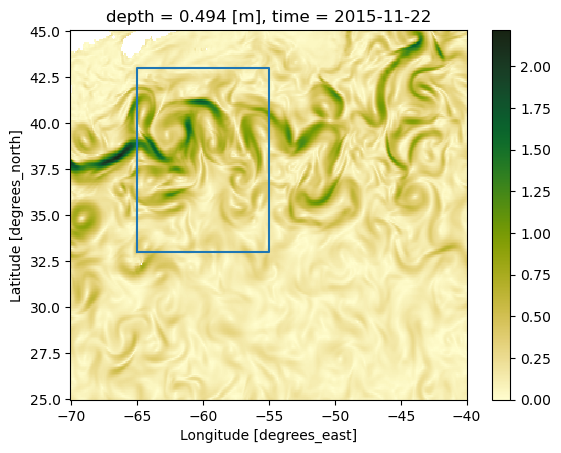

In [14]:
(np.sqrt(ds['uo'].sel(time='2015-11-22')**2+ds['vo'].sel(time='2015-11-22')**2)).plot(cmap = cmocean.cm.speed)
plt.plot([-65,-55,-55,-65,-65],[33,33,43,43,33])

In [24]:
var_stds = {'zos':((ds['zos']-ds_m['zos']).std()), 'thetao':((ds['thetao']-ds_m['thetao']).std()), 'so':((ds['so']-ds_m['so']).std()), 'uo':((ds['uo']-ds_m['uo']).std()), 'vo':((ds['vo']-ds_m['vo']).std())}

In [25]:
var_stds

{'zos': <xarray.DataArray 'zos' ()>
 array(0.12587877),
 'thetao': <xarray.DataArray 'thetao' ()>
 array(2.18212891),
 'so': <xarray.DataArray 'so' ()>
 array(0.35865805),
 'uo': <xarray.DataArray 'uo' ()>
 array(0.17666648),
 'vo': <xarray.DataArray 'vo' ()>
 array(0.17150882)}

In [224]:
ds = ds.chunk(chunks = {'time':30,'latitude':60, 'longitude':90})

In [225]:
ds.to_zarr('input_data/glorys_gulfstream_anomaly_zarr')

In [33]:
mdt = ds['zos'].mean(dim=['time'])
msst = ds['thetao'].mean(dim=['time'])


In [37]:
msss = ds['so'].mean(dim=['time'])
mu = ds['uo'].mean(dim=['time'])
mv = ds['vo'].mean(dim=['time'])

In [52]:
ds_m = xr.Dataset({'zos':mdt,'thetao':msst,'so':msss,'uo':mu,'vo':mv})
ds_m.to_netcdf('input_data/glorys_gulfstream_means.nc')

In [209]:
ds_m = xr.open_dataset('input_data/glorys_gulfstream_means.nc')

In [216]:
list(ds.keys())

['so', 'thetao', 'uo', 'vo', 'zos']

In [217]:
for var in list(ds.keys()):
    print(var)
    ds[var] = ds[var] - ds_m[var]

so
thetao
uo
vo
zos


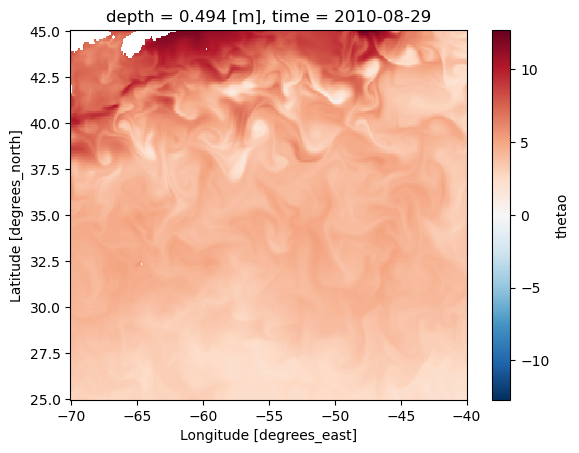

In [223]:
ds['thetao'].isel(time=240).plot()

In [210]:
ds2 = ds - ds_m

KeyboardInterrupt: 

In [58]:
ds.isel(longitude=slice(None,-1))

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 241, longitude: 360, time: 4018)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 25.0 25.08 25.17 25.25 ... 44.83 44.92 45.0
  * longitude  (longitude) float32 -70.0 -69.92 -69.83 ... -40.25 -40.17 -40.08
  * time       (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2020-12-31
Data variables:
    so         (time, depth, latitude, longitude) float32 36.62 36.66 ... 35.74
    thetao     (time, depth, latitude, longitude) float32 24.73 24.63 ... 15.6
    uo         (time, depth, latitude, longitude) float32 0.0116 ... -0.07935
    vo         (time, depth, latitude, longitude) float32 -0.1245 ... 0.07385
    zos        (time, latitude, longitude) float32 0.2411 0.2301 ... -0.3015
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.0.10

In [68]:
isel_args = []
isel_args.append({
                    'latitude': slice(1, 100),
                    'longitude': slice(4, 40),
                    'time': 0
                    })
isel_args.append({
                    'latitude': slice(1, 100),
                    'longitude': slice(4, 40),
                    'time': 0
                    })

In [70]:
ds.isel(isel_args[0])

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 99, longitude: 36)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 25.08 25.17 25.25 25.33 ... 33.08 33.17 33.25
  * longitude  (longitude) float32 -69.67 -69.58 -69.5 ... -66.92 -66.83 -66.75
    time       datetime64[ns] 2010-01-01
Data variables:
    so         (depth, latitude, longitude) float32 36.77 36.76 ... 36.54 36.53
    thetao     (depth, latitude, longitude) float32 24.83 24.81 ... 20.32 20.32
    uo         (depth, latitude, longitude) float32 -0.1184 -0.1331 ... 0.1764
    vo         (depth, latitude, longitude) float32 -0.04578 ... -0.1325
    zos        (latitude, longitude) float32 0.2124 0.2081 ... 0.3006 0.2902
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  1.0.10

In [207]:
!rm -r input_data/glorys_gulfstream_zarr

In [66]:
ds.isel(longitude=slice(None,None)).dims['longitude']

361

In [59]:
class GAN_dataset(Dataset):
    
    def __init__(self, data_dir, latent_dim, n_lon, n_lat, samples_per_day, date_range, variables, var_stds, model_zarr_name, lon_buffers = [None, None], lat_buffers = [None, None], multiprocessing = True):
        self.data_dir = data_dir
        self.latent_dim = latent_dim
        self.n_lon = n_lon
        self.n_lat = n_lat
        self.samples_per_day = samples_per_day
        self.lon_buffers = lon_buffers
        self.lat_buffers = lat_buffers
        self.date_range = date_range
        self.variables = variables
        self.var_stds = var_stds
        self.n_channels = len(variables)
        self.model_zarr_name = model_zarr_name
        
        if not multiprocessing:
            self.ds_model = xr.open_zarr(self.data_dir + self.model_zarr_name)
            
            i_lon_min = self.lon_buffers[0]
            i_lon_max = -self.lon_buffers[1]
            i_lat_min = self.lat_buffers[0]
            i_lat_max = -self.lat_buffers[1]
                
            self.ds_model = self.ds_model.isel(longitude = slice(i_lon_min, i_lon_max), latitude = slice(i_lat_min, i_lat_max), depth = 0, drop = True).sel(time=slice(self.date_range[0],self.date_range[1]), drop = True)
            
            self.N_lon = self.ds_model.dims['longitude']
            self.N_lat = self.ds_model.dims['latitude']
            self.N_time = self.ds_model.dims['time']
            
            # Generate isel arguments
            self.indexer = []
            np.random.seed(1)
            for t in range(self.N_time):
                lat_indices = np.random.choice(self.N_lat - self.n_lat + 1, self.samples_per_day, replace=False)
                lon_indices = np.random.choice(self.N_lon - self.n_lon + 1, self.samples_per_day, replace=False)
                for i in range(lon_indices.shape[0]):# lat_start in lat_indices:
                    # for lon_start in lon_indices:
                    self.indexer.append({
                        'latitude': slice(lat_indices[i], lat_indices[i] + self.n_lat),
                        'longitude': slice(lon_indices[i], lon_indices[i] + self.n_lon),
                        'time': t
                    })
            
            
        
    def __len__(self):
        return int(self.samples_per_day*(self.date_range[1]-self.date_range[0]).days)
    
    def worker_init_fn(self, worker_id):
        self.ds_model = xr.open_dataset(self.data_dir + self.model_zarr_name, engine='zarr')

        i_lon_min = self.lon_buffers[0]
        if self.lon_buffers[1] is not None:
            i_lon_max = -self.lon_buffers[1]
        else:
            i_lon_max = None
        i_lat_min = self.lat_buffers[0]
        if self.lat_buffers[1] is not None:
            i_lat_max = -self.lat_buffers[1]
        else:
            i_lat_max = None

        self.ds_model = self.ds_model.isel(longitude = slice(i_lon_min, i_lon_max), latitude = slice(i_lat_min, i_lat_max), depth = 0, drop = True).sel(time=slice(self.date_range[0],self.date_range[1]), drop = True)

        self.N_lon = self.ds_model.dims['longitude']
        self.N_lat = self.ds_model.dims['latitude']
        self.N_time = self.ds_model.dims['time']

        # Generate isel arguments
        self.indexer = []
        np.random.seed(1)
        for t in range(self.N_time):
            lat_indices = np.random.choice(self.N_lat - self.n_lat + 1, self.samples_per_day, replace=False)
            lon_indices = np.random.choice(self.N_lon - self.n_lon + 1, self.samples_per_day, replace=False)
            for i in range(lon_indices.shape[0]):# lat_start in lat_indices:
                # for lon_start in lon_indices:
                self.indexer.append({
                    'latitude': slice(lat_indices[i], lat_indices[i] + self.n_lat),
                    'longitude': slice(lon_indices[i], lon_indices[i] + self.n_lon),
                    'time': t
                })
        

    def __getitem__(self, idx):
        
        invar = torch.from_numpy(np.random.randn(self.latent_dim))
        
        data_model = self.ds_model.isel(self.indexer[idx])
        
        outvar = np.zeros((self.n_channels, self.n_lat, self.n_lon))
        for v, var in enumerate(self.variables):
            outvar[v,] = data_model[var]/self.var_stds[var]
        
        outvar = torch.from_numpy(outvar.astype(np.float32))
        outvar = torch.nan_to_num(outvar, nan=0.0)
        
        return invar, outvar

In [60]:
dataset = GAN_dataset(data_dir = './input_data/', latent_dim = 64, n_lon = 128, n_lat = 128, samples_per_day = 16, date_range = [date(2019,1,1),date(2020,12,31)], variables = ['zos', 'thetao', 'so', 'uo', 'vo'], var_stds = var_stds, model_zarr_name = 'glorys_gulfstream_anomaly_zarr', lon_buffers = [3, None], lat_buffers = [None, 2], multiprocessing = True)

In [61]:
len(dataset)/(date(2020,12,31)-date(2019,1,1)).days

16.0

In [62]:
batch_size = 25
n_cpus = 2
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpus, worker_init_fn = dataset.worker_init_fn,persistent_workers=True)

In [63]:
%%time
for step, (x, y) in enumerate(dataloader):
    print(step)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x2b0493732d40>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x2b0493732d40>Traceback (most recent call last):

  File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    
 if w.is_alive(): 
          ^ ^ ^^^^^^^^^^^^^^^^^^^^^
  File "/dat1/smart1n/miniconda3/envs/neurost/lib/python3.11/multiproces

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


KeyboardInterrupt: 

In [64]:
dataloader._iterator. _shutdown_workers()

In [50]:
x.shape

torch.Size([25, 64])

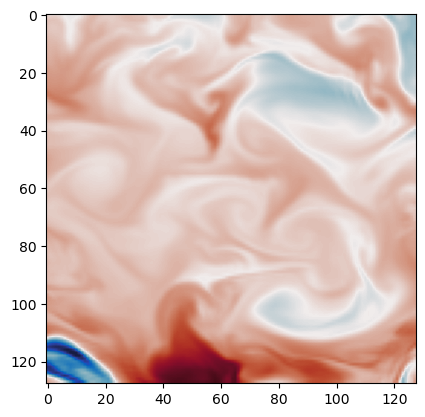

In [51]:
idx = 0
# plt.imshow(np.sqrt(y[idx,3,]**2+y[idx,4,]**2), cmap = cmocean.cm.ice, vmin = 0, vmax = 3)
plt.imshow(y[idx,2,], cmap = cmocean.cm.balance, vmin = -3, vmax = 3)

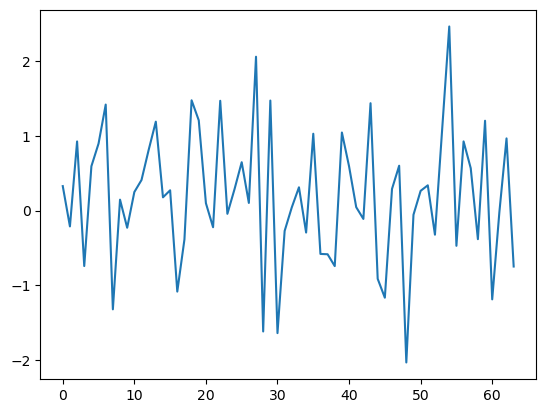

In [186]:
plt.plot(x[idx,])